In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.metrics import accuracy_score

df_movies = pd.read_csv('data/movie_reviews_processed.csv')

X = df_movies.filter(regex='_sc$')
y = df_movies['rating_good']

In [32]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
heart_disease = fetch_ucirepo(id=45)

# data (as pandas dataframes)
X = heart_disease.data.features
y = heart_disease.data.targets

# metadata
# print(heart_disease.metadata)

# variable information
# print(heart_disease.variables)

df_heart = (
    X
    .assign(
        cp = pd.Categorical(X.cp).rename_categories(['typical', 'atypical', 'non-anginal', 'asymptomatic']),
        fbs = pd.Categorical(X.fbs).rename_categories(['<= 120 mg/dl', '> 120 mg/dl']),
        restecg = pd.Categorical(X.restecg).rename_categories(['normal', 'ST-T wave abnormality', 'left ventricular hypertrophy']),
        exang = pd.Categorical(X.exang).rename_categories(['no', 'yes']),
        slope = pd.Categorical(X.slope).rename_categories(['upsloping', 'flat', 'downsloping']),
        # ca = pd.Categorical(X.ca, categories = ['0', '1', '2', '3']),
        thal = pd.Categorical(X.thal).rename_categories(['normal', 'fixed defect', 'reversible defect']),
        heart_disease = pd.Categorical(y.num > 0).rename_categories(['no', 'yes'])
    )
    .rename(
        columns={
            'sex': 'male',
            'cp': 'chest_pain_type',
            'trestbps': 'resting_bp',
            'chol': 'cholesterol',
            'fbs': 'fasting_blood_sugar',
            'restecg': 'resting_ecg',
            'thalach': 'max_heart_rate',
            'exang': 'exercise_induced_angina',
            'oldpeak': 'st_depression',
            'ca': 'num_major_vessels',
            'thal': 'thalassemia',
        }
    )
    .assign(
        fasting_blood_sugar_num=lambda x: x.fasting_blood_sugar.cat.codes,
        resting_ecg_num=lambda x: x.resting_ecg.cat.codes,
        exercise_induced_angina_num=lambda x: x.exercise_induced_angina.cat.codes,
        heart_disease_num=lambda x: x.heart_disease.cat.codes,
    )
)

df_heart.head()

,age,male,chest_pain_type,resting_bp,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_induced_angina,st_depression,slope,num_major_vessels,thalassemia,heart_disease,fasting_blood_sugar_num,resting_ecg_num,exercise_induced_angina_num,heart_disease_num
0,63,1,typical,145,233,> 120 mg/dl,left ventricular hypertrophy,150,no,2.3,downsloping,0.0,fixed defect,no,1,2,0,0
1,67,1,asymptomatic,160,286,<= 120 mg/dl,left ventricular hypertrophy,108,yes,1.5,flat,3.0,normal,yes,0,2,1,1
2,67,1,asymptomatic,120,229,<= 120 mg/dl,left ventricular hypertrophy,129,yes,2.6,flat,2.0,reversible defect,yes,0,2,1,1
3,37,1,non-anginal,130,250,<= 120 mg/dl,normal,187,no,3.5,downsloping,0.0,normal,no,0,0,0,0
4,41,0,atypical,130,204,<= 120 mg/dl,left ventricular hypertrophy,172,no,1.4,upsloping,0.0,normal,no,0,2,0,0


In [31]:
pd.Categorical(y.num)#.rename_categories(['typical', 'atypical', 'non-anginal', 'asymptomatic'])

[0, 2, 1, 0, 0, ..., 1, 2, 3, 1, 0]
Length: 303
Categories (5, int64): [0, 1, 2, 3, 4]

In [2]:
# Fit model

model = LogisticRegressionCV(
  penalty   = 'elasticnet', 
  l1_ratios = np.arange(.0, 1, .05), 
  cv     = 5, 
  solver = 'saga', 
  random_state = 123,
  verbose = False
)

model.fit(X, y)

# Predict

y_pred = model.predict(X)

# Evaluate

print(
  'Training accuracy: ', accuracy_score(y, y_pred),
  'Baseline Prevalence: ', np.mean(y)
)

Training accuracy:  0.68 Baseline Prevalence:  0.563


## Vis/Interpretation

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df_heart = pd.read_csv('data/heart_disease_processed.csv')
df_heart_num = pd.read_csv('data/heart_disease_processed_numeric_sc.csv')

# convert appropriate features to categorical
for col in df_heart.select_dtypes(include='object').columns:
    df_heart[col] = df_heart[col].astype('category')

X = df_heart_num.drop(columns=['heart_disease']).to_numpy()
y = df_heart_num['heart_disease'].to_numpy()

# for LogisticRegression, which can't automatically handle missing data
y_complete = df_heart_num.dropna()['heart_disease'].to_numpy().astype(int)
X_complete = df_heart_num.dropna().drop(columns='heart_disease').to_numpy()

X_train, X_test, y_train, y_test = train_test_split(
    df_heart.drop(columns='heart_disease'), df_heart_num['heart_disease'], test_size=0.2, random_state=42
)

In [64]:
import joblib

cv_boost_tune = joblib.load('ml/data/tune-boost-py-model.pkl')


['age',
 'male',
 'chest_pain_type',
 'resting_bp',
 'cholesterol',
 'fasting_blood_sugar',
 'resting_ecg',
 'max_heart_rate',
 'exercise_induced_angina',
 'st_depression',
 'slope',
 'num_major_vessels',
 'thalassemia']

In [65]:
# Get feature importances
feature_importances = pd.DataFrame({'Feature': cv_boost_tune.feature_name_,
                                   'Importance': cv_boost_tune.feature_importances_})

# Sort the dataframe by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the dataframe
print(feature_importances)


                    Feature  Importance
4               cholesterol         949
7            max_heart_rate         903
0                       age         859
9             st_depression         694
3                resting_bp         611
11        num_major_vessels         369
12              thalassemia         342
10                    slope         250
1                      male         235
6               resting_ecg         226
8   exercise_induced_angina         191
5       fasting_blood_sugar          79
2           chest_pain_type           5


PyALE._ALE_generic:INFO: Continuous feature detected.


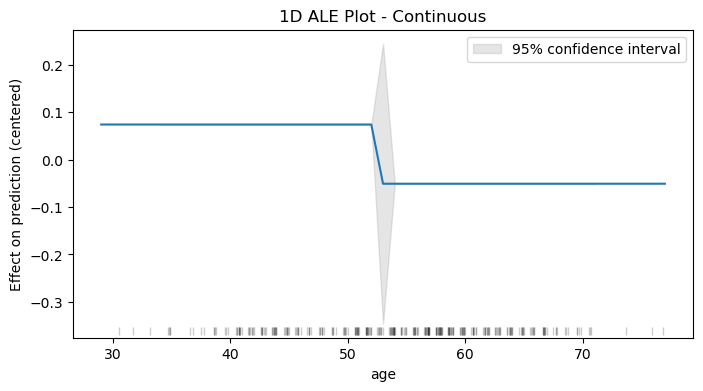

In [66]:
from PyALE import ale

ale_eff = ale(
    X=df_heart.drop(columns='heart_disease'), 
    model=cv_boost_tune, feature=["age"], 
    grid_size=3000, 
    # include_CI=True
)

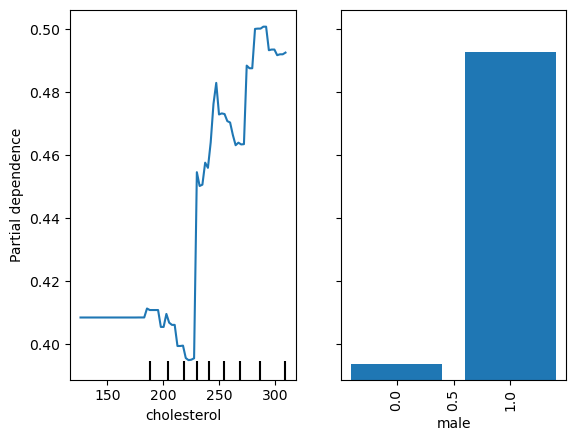

In [67]:
import pandas as pd
import numpy as np
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    cv_boost_tune, 
    df_heart.drop(columns='heart_disease'), 
    features=['cholesterol', 'male'], 
    categorical_features=['male'], 
    percentiles=(0, .9),
    grid_resolution=75
)
